# Example analysis from AFQ-browser data

In the following notebook, we will demonstrate how to download, process and analyze data that is provided through an 
instance of AFQ-Browser. 

The data are described in [a paper by Sarica et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hbm.23412/abstract), and it contains diffusion MRI (dMRI) images from brains of participants with ALS and matched control subjects. 

The AFQ-browser instance that displays these data can be found at: https://yeatmanlab.github.io/Sarica_2017

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Download

We download the data directly from the AFQ-Browser website. 

One file contains the processed dMRI data, in the form of a 'tidy' table that describes several diffusion statistics (such as MD, FA, etc.) along the length of the 20 different fiber groups that AFQ analyzes. 

The `pandas` library allows us to read the data directly from the URL (but we could also use the "download data" buttons, if we wish to save the data locally): 

In [3]:
df_nodes = pd.read_csv("http://yeatmanlab.github.io/Sarica_2017/data/nodes.csv")

Another table contains metadata about the subjects (for example whether they are patients or controls):

In [4]:
df_subjects = pd.read_json("http://yeatmanlab.github.io/Sarica_2017/data/subjects.json")

We use `pandas` to merge the two tables together

In [5]:
df = pd.merge(df_nodes, df_subjects, on="subjectID")

# Process and visualize 

The following cell pulls the data from the table, and uses `seaborn` to visualize the FA and MD in 
each group of subjects, along the length of each tract. This replicates the plots in Figure 5 of our article:

/Users/arokem/anaconda3/lib/python3.5/site-packages/seaborn/algorithms.py:76: RuntimeWarning: Mean of empty slice
  boot_dist.append(func(*sample, **func_kwargs))


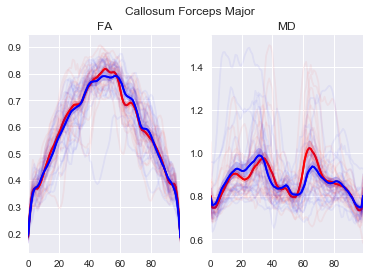

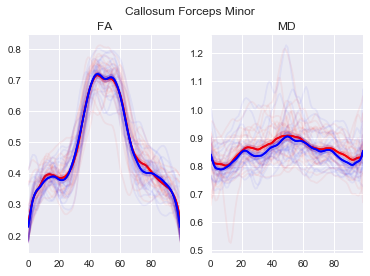

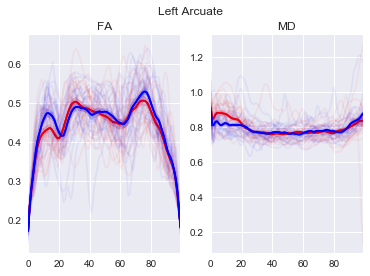

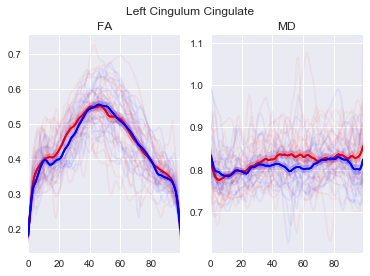

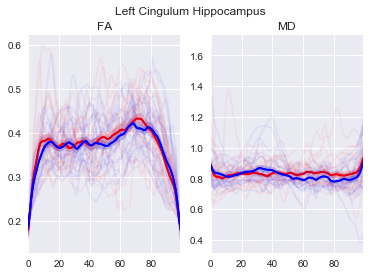

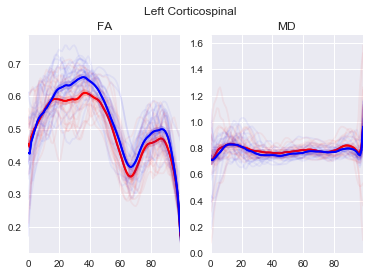

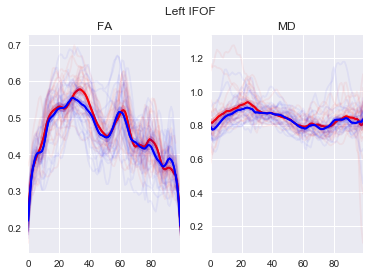

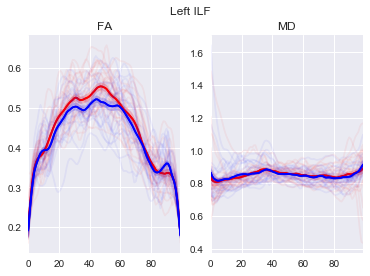

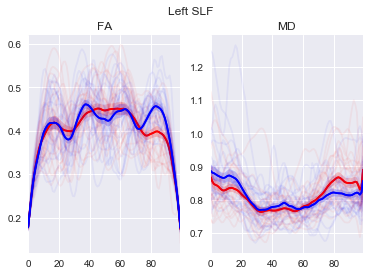

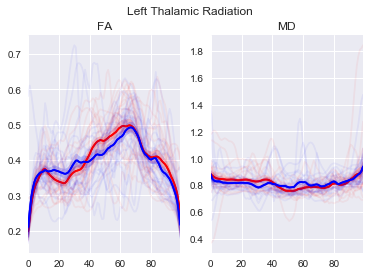

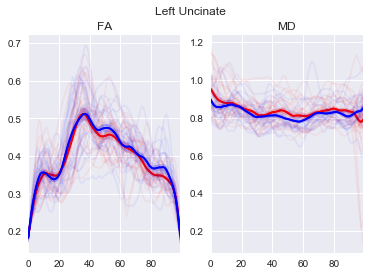

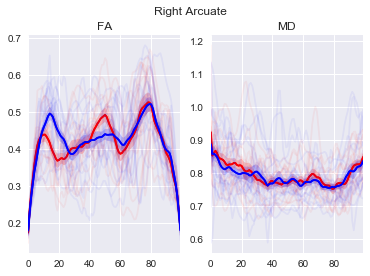

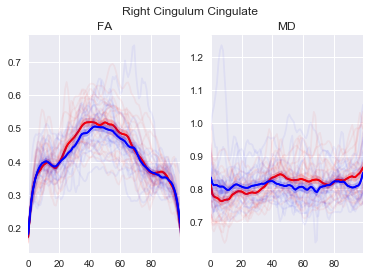

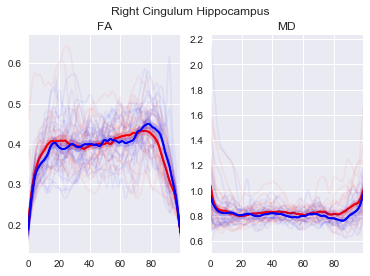

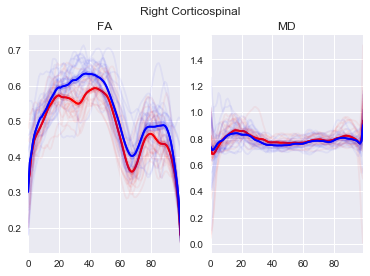

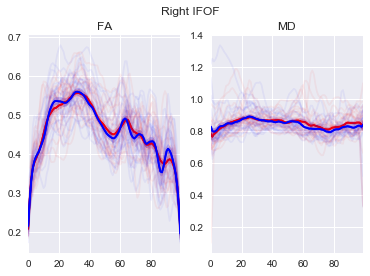

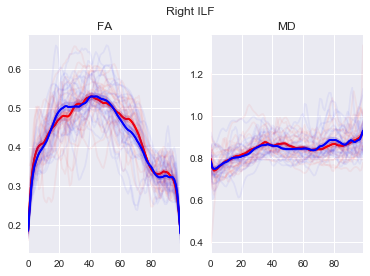

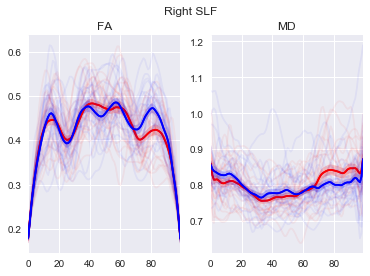

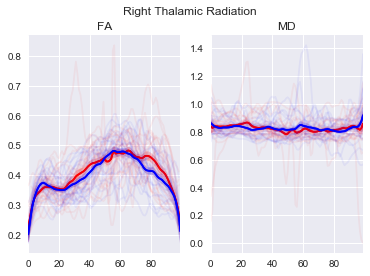

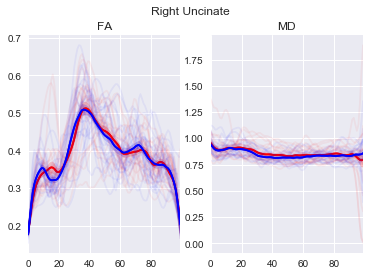

In [6]:
colors = {'ALS': 'r', 'CTRL': 'b'}

gb_tracts = df.groupby('tractID')
for tract_name, tract_df in gb_tracts: 
    fig, ax = plt.subplots(1, 2)
    gb_als = tract_df.groupby('class')
    for c, df_c in gb_als:
        for ax_idx, value in enumerate(['fa', 'md']):
            tract_p = df_c.pivot(index='nodeID', columns='subjectID', values=value) 
            sns.tsplot(tract_p.values.T, err_style="unit_traces", estimator=np.nanmean,
                       err_kws={'alpha':0.05}, ax=ax[ax_idx], color=colors[c])
            sns.tsplot(tract_p.values.T, ax=ax[ax_idx], color=colors[c], estimator=np.nanmean)
            fig.suptitle(tract_name)
            ax[ax_idx].set_title(value.upper())

# Analyze 

Following Sarica et al., we focus our analysis on the corticospinal tract. We select the parts of the data that contain information about these two tracts:

In [7]:
df_cst = df[(df['tractID'] == "Left Corticospinal") | (df['tractID'] == "Right Corticospinal")]

For analysis with Scikit Learn, we extract a matrix that contains the FA values:

In [8]:
fa = df_cst['fa'].values.reshape((df_subjects.shape[0], -1))

As in the original article, we remove nodes that have missing values

In [9]:
idx = np.where(~np.isnan(np.mean(fa, 0)))
fa = fa[:, idx].squeeze()

This results in a matrix with 48 rows (number of subjects) and 181 columns (the total number of nodes in the two corticospinal tracts, minus the nodes that have missing values).

In [10]:
fa.shape

(48, 181)

We also generate a binary array representing the true classes of the participants

In [11]:
y = np.array([{'ALS':1, 'CTRL':0}[c] for c in df_subjects['class']])

We will use an unsupervised learning technique, a Gaussian Mixture Model (GMM), to learn a division of the data into two clusters, based only on FA in the corticospinal tracts.

To visualize the operation of this algorithm on the data, we will first apply a Principal Components Analysis, 
which reduces the dimensionality of the data, and allows to see approximately how the data is separated:

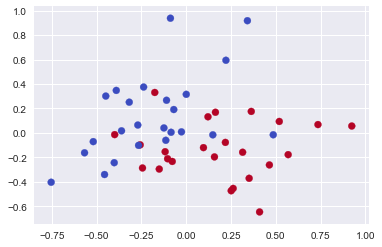

In [12]:
from sklearn.decomposition import PCA
my_pca = PCA(0.9) 
Xpca = my_pca.fit_transform(fa)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=y, cmap='coolwarm')

This already shows that the data is quite well separated, even only on the first two principal components. Next, we fit the GMM:

In [13]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(2)
gmm.fit(fa)
y_pred = gmm.predict(fa)

We can see that the GMM simplifies the prediction, mis-classifying many cases in which participants' data overlaps in the space of the two PCs:

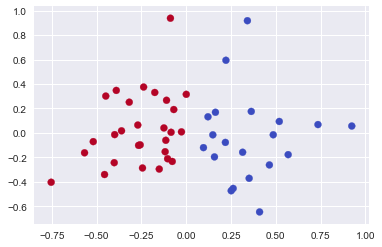

In [14]:
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=y_pred, cmap='coolwarm')

Nevertheless, even this very simplistic learning algorithm reaches approximately 80% correct in discrimination based on these data. Since it's unsupervised, it can only discriminate, rather than classify, so we take the better of the two comparisons as a basis for assessing procent correct:

In [15]:
np.max([np.mean(y == y_pred), 1 - np.mean(y == y_pred)])

0.75

This initial exploration gives us an indication that it would be possible to construct an accurate classifier based on this data (in addition to the previous results by Sarica et al. that have successfully done so in their paper, based on these data).

Next, we'll try a supervised learning method: a support vector machine with a polynomial kernel

In [16]:
from sklearn.svm import SVC

In [17]:
clf = SVC(kernel='poly', degree=4)

In [18]:
clf.fit(fa, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=4, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We can visualize the performance of the classifier by demonstrating what it would have predicted for points in the space of the first and second principal components of the FA:

In [19]:
x_min = -1 
x_max = 1
y_min = -1
y_max = 1
h = .02

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

pc_space = np.hstack([np.c_[xx.ravel(), yy.ravel()],
                      np.zeros((xx.ravel().shape[0], 10))])

fa_space = my_pca.inverse_transform(pc_space)
z = clf.predict(fa_space)
z = z.reshape(xx.shape)

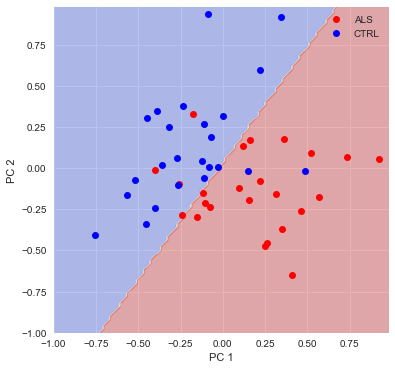

In [20]:
fig, ax = plt.subplots(1)
ax.contourf(xx, yy, z, cmap=plt.cm.coolwarm, alpha=0.4)
for ii, c in enumerate(['ALS', 'CTRL']):
    ax.plot(Xpca[ii*24:(ii+1)*24, 0], 
            Xpca[ii*24:(ii+1)*24, 1], 'o', color=colors[c], 
            label=c)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
fig.set_size_inches([6,6])
plt.legend()

We can see that it mis-classifies approximately 5 of the participants (almost 90% accuracy!). This gives us an intuition for the accuracy of the classifier. More accurately, we can use cross-validation, to iteratively fit the classifier to some data points, and predict the left out points. We will use the default 3-fold cross-validation scheme implemented in Scikit Learn to do so:

In [21]:
from sklearn.model_selection import cross_val_score

In [34]:
scores = cross_val_score(clf, fa, y)

In [36]:
print("Accuracy: %0.2f" %scores.mean())

Accuracy: 0.88
